In [99]:
from lambeq import BobcatParser, SpacyTokeniser
import torch, numpy, pandas as pd, re

In [100]:
def clean_text(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    text =  ' '.join(text.split())
    #print(text)
    return text

In [103]:
def process_csv_lines(input_file_path, output_file_path):
    """
    Reads a CSV file, processes each line to remove all commas except the last one,
    and writes the processed lines to a new file.
    """
    with open(input_file_path, 'r', encoding='utf-8') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
        for line in input_file:
            if ',' in line:
                parts = line.rsplit(',', 1)  # Split from the right at the last comma
                new_line = parts[0].replace(',', '') # Remove all commas from the first part
            else:
                new_line = line  # If no comma is present, leave the line unchanged
            
            output_file.write(clean_text(new_line)+ ',' + parts[1])



In [104]:
# Process Train dataset 
input_file = "train_dataset.csv"
output_file = "train_clean_data.csv"
process_csv_lines(input_file,output_file)

In [105]:
# Process Test dataset
input_file = "test_dataset.csv"
output_file = "test_clean_data.csv"
process_csv_lines(input_file,output_file)

In [106]:
train_dataset = pd.read_csv("train_clean_data.csv").sample(frac = 1)
test_dataset = pd.read_csv("test_clean_data.csv").sample(frac = 1)

In [107]:
train_dataset[:10]

,absolutely love this product,0
67,the interface is intuitive but lacks key features,3
87,the games multiplayer mode is exhilarating but...,3
13,perfect day,0
58,decent choice but there are better options out...,2
119,the product did not meet my expectations in te...,1
72,good attempt but needs more polish,3
136,fast delivery but the package arrived damaged,3
27,customer service was rude and unhelpful,1
109,the train departs every hour on the half hour,2
56,middle of the road in every aspect,2


In [108]:
test_dataset[:10]

,the book was published in by penguin classics,2
14,the novels pacing was sluggish making it chore...,1
5,please submit the report by the end of the week,2
31,the novels plot was compelling but the writing...,3
12,the software is bug ridden and crashes frequently,1
32,while the software is powerful its incredibly ...,3
23,such heartwarming story left me in tears of joy,0
13,despite the hype the gadget feels gimmicky and...,1
38,the cars performance is unmatched but the inte...,3
1,the meeting is scheduled for pm tomorrow,2
20,his performance was breathtaking capturing the...,0


In [109]:
train_data = train_dataset.iloc[:, 0].to_list()
train_labels = train_dataset.iloc[:, 1].to_list()

In [110]:
test_data = test_dataset.iloc[:, 0].to_list()
test_labels = test_dataset.iloc[:, 1].to_list()

In [111]:
parser = BobcatParser(root_cats=('NP', 'N'))
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences:   0%|          | 0/35 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/139 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/139 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/10 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/39 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/39 [00:00<?, ?it/s]

In [112]:
print("Number of Train diagrams", len(train_diagrams), "and labels", len(train_labels), "match? ->", len(train_diagrams) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams), "and labels", len(test_labels), "match? ->", len(test_diagrams) == len(test_labels))

Number of Train diagrams 139 and labels 139 match? -> True
Number of Test diagrams 39 and labels 39 match? -> True


In [113]:
train_diagrams_filter = []

for index,diagram in enumerate(train_diagrams):
    if diagram is not None:
        train_diagrams_filter.append(diagram.normal_form())
    else:
        train_labels[index] = None
        
test_diagrams_filter = []

for index,diagram in enumerate(test_diagrams):
    if diagram is not None:
        test_diagrams_filter.append(diagram.normal_form())
    else:
        test_labels[index] = None

In [114]:
def remove_none(ll):
    return [x for x in ll if x is not None]

train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [115]:
print("Number of Train diagrams", len(train_diagrams_filter), "and labels", len(train_labels), "match? ->", len(train_diagrams_filter) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams_filter), "and labels", len(test_labels), "match? ->", len(test_diagrams_filter) == len(test_labels))

Number of Train diagrams 121 and labels 121 match? -> True
Number of Test diagrams 32 and labels 32 match? -> True


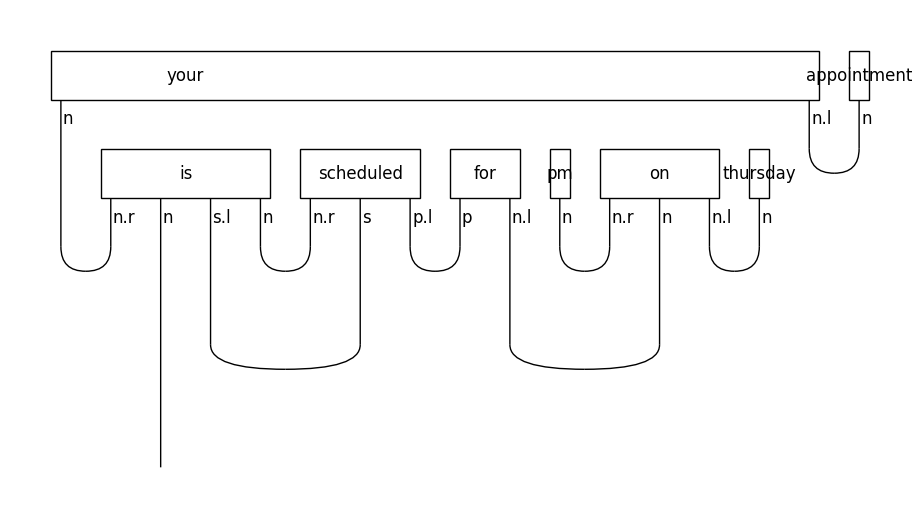

In [116]:
train_diagrams_filter[10].normal_form().draw(figsize=(9, 5), fontsize=12)

In [139]:
from lambeq import AtomicType, IQPAnsatz, SpiderAnsatz, RemoveCupsRewriter

# Define types for the ansatz
noun = AtomicType.NOUN
sentence_type = AtomicType.SENTENCE
prep = AtomicType.PREPOSITIONAL_PHRASE

# Create an ansatz (IQPAnsatz in this example)
ansatz = IQPAnsatz({prep:1, noun: 2, sentence_type: 1},n_layers=1,n_single_qubit_params=5)

remove_cups = RemoveCupsRewriter()

train_circuits = []
test_circuits =  []

for index, diag in enumerate(train_diagrams_filter):
    try:
        train_circuits.append(ansatz(remove_cups(diag)))
    except Exception as e:
        print("Problem with Train diagram",index, "-> sentence is:", train_dataset.iloc[index,0])
        train_labels[index] = None
        print(e)

for index,diag in enumerate(test_diagrams_filter):
    try:
        test_circuits.append(ansatz(remove_cups(diag)))
    except Exception as e:
        print("Problem with Test diagram",index, "-> sentence is:", test_dataset.iloc[index,0])
        test_labels[index] = None
        #print(e)



#train_circuits[0].draw(figsize=(9, 10))

Problem with Train diagram 20 -> sentence is: nothing to complain about but nothing to praise either
Diagram 0 (cod=s.r @ s.r.r @ s.r @ n.r.r @ n.r @ n @ n.l @ n.l.l @ s.l @ n @ n.r @ s) does not compose with diagram 1 (dom=s.r @ n.r.r @ n.r.r @ n.r @ n @ n.l @ n.l.l @ s.l @ n @ n.r @ s)
Problem with Train diagram 81 -> sentence is: affordable but you get what you pay for
Diagram 0 (cod=n @ n.r @ n @ n.l @ n.l) does not compose with diagram 1 (dom=n @ n.r @ n.l @ n.l)


In [118]:
train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [119]:
print("Number of Train circuits", len(train_circuits), "and labels", len(train_labels), "match? ->", len(train_circuits) == len(train_labels))
print("Number of Test circuits", len(test_circuits), "and labels", len(test_labels), "match? ->", len(test_circuits) == len(test_labels))

Number of Train circuits 119 and labels 119 match? -> True
Number of Test circuits 32 and labels 32 match? -> True


In [120]:
"""
train_diagrams_filter[7].draw(figsize=(9, 1.5))
train_diagrams_filter[43].draw()
train_diagrams_filter[51].draw()
"""

'\ntrain_diagrams_filter[7].draw(figsize=(9, 1.5))\ntrain_diagrams_filter[43].draw()\ntrain_diagrams_filter[51].draw()\n'

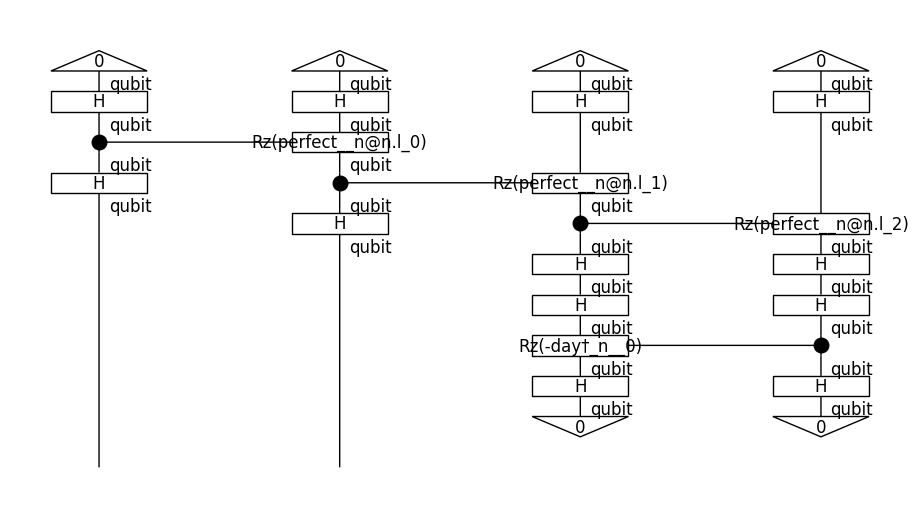

In [121]:
train_circuits[2].draw(figsize=(9, 5), fontsize=12)

In [66]:
# TESTING

'''
# Parse a sentence into a diagram
parser = BobcatParser(verbose='text')
sentence = "This is a simple example."
ccg_diagram = parser.sentence2diagram(sentence)

# Define types for the ansatz
noun = AtomicType.NOUN
sentence_type = AtomicType.SENTENCE

# Create an ansatz (IQPAnsatz in this example)
ansatz = IQPAnsatz({noun: 2, sentence_type: 1},n_layers=1,n_single_qubit_params=3)

# Convert the CCG diagram into a quantum circuit
circuit = ansatz(train_diagrams_filter[0])

# Now `circuit` is a pytket circuit ready for simulation or running on a quantum computer
circuit.draw()
'''

'\n# Parse a sentence into a diagram\nparser = BobcatParser(verbose=\'text\')\nsentence = "This is a simple example."\nccg_diagram = parser.sentence2diagram(sentence)\n\n# Define types for the ansatz\nnoun = AtomicType.NOUN\nsentence_type = AtomicType.SENTENCE\n\n# Create an ansatz (IQPAnsatz in this example)\nansatz = IQPAnsatz({noun: 2, sentence_type: 1},n_layers=1,n_single_qubit_params=3)\n\n# Convert the CCG diagram into a quantum circuit\ncircuit = ansatz(train_diagrams_filter[0])\n\n# Now `circuit` is a pytket circuit ready for simulation or running on a quantum computer\ncircuit.draw()\n'

In [67]:
# Testing with SpiderAnsatz

"""
from lambeq.backend.tensor import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

remove_cups = RemoveCupsRewriter()

train_circuits = []
test_circuits =  []


for index, diag in enumerate(train_diagrams_filter):
    try:
        train_circuits.append(ansatz(remove_cups(diag)))
    except Exception as e:
        print("Problem with Train diagram",index)
        train_labels[index] = None
        print(e)

for index,d in enumerate(test_diagrams_filter):
    try:
        test_circuits.append(ansatz(remove_cups(diag)))
    except Exception as e:
        print("Problem with Test diagram",index)
        test_labels[index] = None
        print(e)
"""

'\nfrom lambeq.backend.tensor import Dim\n\nfrom lambeq import AtomicType, SpiderAnsatz\n\nansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),\n                       AtomicType.SENTENCE: Dim(2)})\n\nremove_cups = RemoveCupsRewriter()\n\ntrain_circuits = []\ntest_circuits =  []\n\n\nfor index, diag in enumerate(train_diagrams_filter):\n    try:\n        train_circuits.append(ansatz(remove_cups(diag)))\n    except Exception as e:\n        print("Problem with Train diagram",index)\n        train_labels[index] = None\n        print(e)\n\nfor index,d in enumerate(test_diagrams_filter):\n    try:\n        test_circuits.append(ansatz(remove_cups(diag)))\n    except Exception as e:\n        print("Problem with Test diagram",index)\n        test_labels[index] = None\n        print(e)\n'

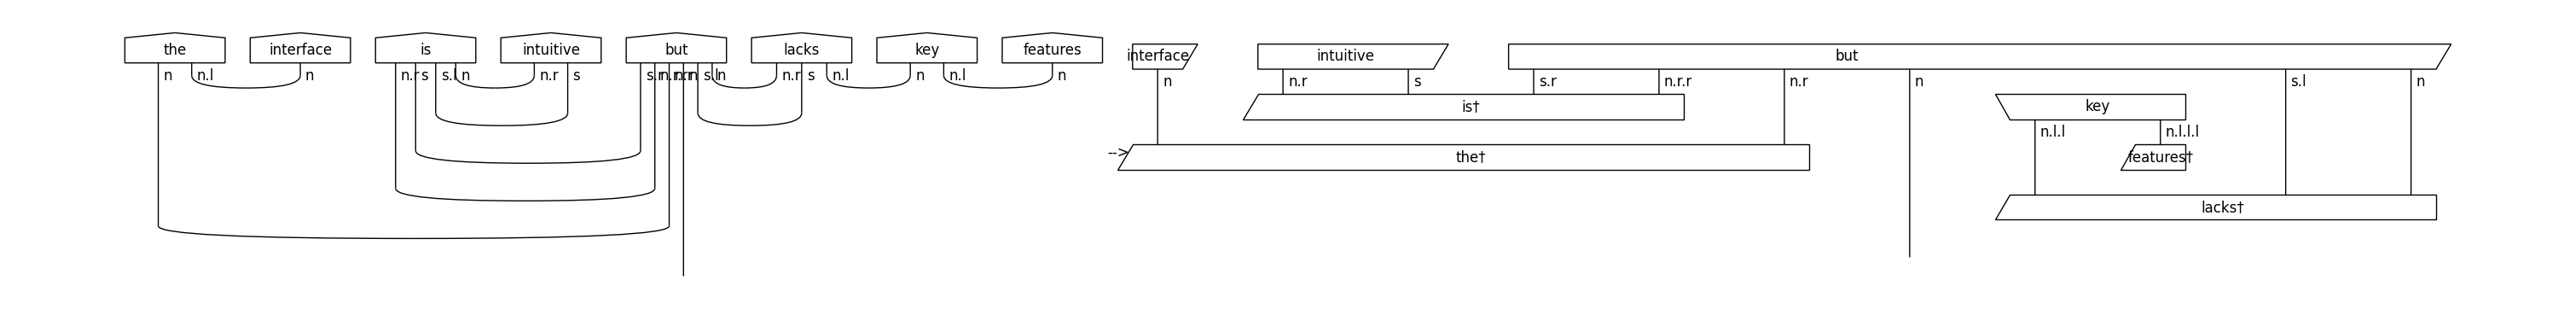

In [122]:
from lambeq.backend import draw_equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

draw_equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(30, 6), asymmetry=0.3, fontsize=12)

## Training

In [123]:
sig = torch.sigmoid
def accuracy(y_pred, y_true):
    y_pred = sig(y_pred)
    y_pred = torch.round(y_pred)
    return torch.sum(y_pred == y_true).item() / len(y_true)

eval_metrics = {"accuracy": accuracy}

In [133]:
sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": accuracy}

In [134]:
BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0


In [132]:
from lambeq import PytorchModel

all_circuits = train_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

In [138]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text')

AttributeError: 'Symbol' object has no attribute 'size'